[View in Colaboratory](https://colab.research.google.com/github/silentvoice/dl-with-keras/blob/master/classification_cats_vs_dogs_by_extending_pretrained_model.ipynb)

# Classification Cats Vs Dogs Using Pre-trained Model

In [0]:
# this resets the state of the machine (e.g. if you want to re-install from scratch  # this  
# or reset memory usage in this instance)
# wait a minute after running it and then reload the page
!kill -9 -1

## Check Tensorflow Version

In [0]:
import tensorflow as tf

In [2]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
tf.__version__

'1.9.0-rc2'

## Imports

In [0]:
from tensorflow import keras
from tensorflow.python.keras import layers, models, optimizers
from tensorflow.python.keras.preprocessing import image
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.applications import VGG16
import numpy as np
import matplotlib.pyplot as plt
import os, shutil


## Load Kaggle Dogs Dataset

In [0]:
# Run this cell and select the kaggle.json file downloaded
# from the Kaggle account settings page.
from google.colab import files
files.upload()

In [7]:
# Check if the kaggle.json file is present.
!ls -lha kaggle.json

-rw-r--r-- 1 root root 66 Jul  6 15:36 kaggle.json


In [0]:
# Install the Kaggle API client.
!pip install -q kaggle

In [0]:
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 /content/.kaggle/kaggle.json

In [10]:
# Download dataset from kaggle
!mkdir -p data/cats-vs-dogs && kaggle competitions download -c dogs-vs-cats -p data/cats-vs-dogs/

  0%|                                               | 0.00/86.8k [00:00<?, ?B/s]
100%|██████████████████████████████████████| 86.8k/86.8k [00:00<00:00, 31.0MB/s]
 99%|████████████████████████████████████████▌| 268M/271M [00:02<00:00, 161MB/s]
100%|█████████████████████████████████████████| 271M/271M [00:02<00:00, 123MB/s]
 98%|████████████████████████████████████████▏| 532M/543M [00:03<00:00, 147MB/s]
100%|█████████████████████████████████████████| 543M/543M [00:03<00:00, 157MB/s]


In [0]:
!mkdir data/cats-vs-dogs/orig_data && unzip data/cats-vs-dogs/train.zip -d data/cats-vs-dogs/orig_data/

In [0]:
orig_data_dir = '/content/data/cats-vs-dogs/orig_data/train'

In [0]:
base_dir = '/content/data/small-cats-vs-dogs'
os.mkdir(base_dir)

In [0]:
# Create Train, Validation and Test folders
train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)
validation_dir = os.path.join(base_dir, 'validation')
os.mkdir(validation_dir)
test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)

In [0]:
# Prepare folders for cats and dogs  
train_cats_dir = os.path.join(train_dir, 'cats')
os.mkdir(train_cats_dir)
train_dogs_dir = os.path.join(train_dir, 'dogs')
os.mkdir(train_dogs_dir)

validation_cats_dir = os.path.join(validation_dir, 'cats')
os.mkdir(validation_cats_dir)
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
os.mkdir(validation_dogs_dir)

test_cats_dir = os.path.join(test_dir, 'cats')
os.mkdir(test_cats_dir)
test_dogs_dir = os.path.join(test_dir, 'dogs')
os.mkdir(test_dogs_dir)

In [16]:
!ls data/cats-vs-dogs/orig_data/train | head


cat.0.jpg
cat.10000.jpg
cat.10001.jpg
cat.10002.jpg
cat.10003.jpg
cat.10004.jpg
cat.10005.jpg
cat.10006.jpg
cat.10007.jpg
cat.10008.jpg
ls: write error: Broken pipe


In [0]:
# create a smaller train, validation and test dataset from orig_data
train_cat_f_names = ['cat.{}.jpg'.format(i) for i in range(1000)]
train_dog_f_names = ['dog.{}.jpg'.format(i) for i in range(1000)]

val_cat_f_names = ['cat.{}.jpg'.format(i) for i in range(1000, 1500)]
val_dog_f_names = ['dog.{}.jpg'.format(i) for i in range(1000, 1500)]

test_cat_f_names = ['cat.{}.jpg'.format(i) for i in range(1500, 2000)]
test_dog_f_names = ['dog.{}.jpg'.format(i) for i in range(1500, 2000)]

In [0]:
for f_name in train_cat_f_names:
  src = os.path.join(orig_data_dir, f_name)
  dst = os.path.join(train_cats_dir, f_name)
  shutil.copyfile(src, dst)
  
for f_name in val_cat_f_names:
  src = os.path.join(orig_data_dir, f_name)
  dst = os.path.join(validation_cats_dir, f_name)
  shutil.copyfile(src, dst)
  
for f_name in test_cat_f_names:
  src = os.path.join(orig_data_dir, f_name)
  dst = os.path.join(test_cats_dir, f_name)
  shutil.copyfile(src, dst)

for f_name in train_dog_f_names:
  src = os.path.join(orig_data_dir, f_name)
  dst = os.path.join(train_dogs_dir, f_name)
  shutil.copyfile(src, dst)
  
for f_name in val_dog_f_names:
  src = os.path.join(orig_data_dir, f_name)
  dst = os.path.join(validation_dogs_dir, f_name)
  shutil.copyfile(src, dst)
  
for f_name in test_dog_f_names:
  src = os.path.join(orig_data_dir, f_name)
  dst = os.path.join(test_dogs_dir, f_name)
  shutil.copyfile(src, dst) 

In [0]:
len(os.listdir(train_cats_dir))

1000

In [21]:
len(os.listdir(train_dogs_dir))

1000

## Data Preparation 


In [23]:
train_data_gen = ImageDataGenerator(rescale=1./255,
                                    rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest')

val_data_gen = ImageDataGenerator(rescale=1./255)

train_generator = train_data_gen.flow_from_directory(train_dir,
                                                    target_size=(150, 150),
                                                    batch_size=20,
                                                    class_mode='binary')

validation_generator = val_data_gen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## VGG16 Resnet Base Model

In [24]:
conv_base = VGG16(weights='imagenet',
                    include_top=False,
                    input_shape=(150, 150, 3))

58892288/58889256 [==============================] - 2s 0us/step


In [25]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

## Extend the base model

In [0]:
model = models.Sequential()

model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [0]:
conv_base.trainable = False

In [0]:
model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])


In [29]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dropout (Dropout)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


## Train the Model

In [30]:
model_history = model.fit_generator(train_generator,
                                    steps_per_epoch=100,
                                    epochs=30,
                                    validation_data=validation_generator,
                                    validation_steps=50,
                                    verbose=2)

Epoch 1/30
 - 32s - loss: 0.6724 - acc: 0.5880 - val_loss: 0.5107 - val_acc: 0.8030
Epoch 2/30
 - 28s - loss: 0.5743 - acc: 0.6875 - val_loss: 0.4519 - val_acc: 0.7960
Epoch 3/30
 - 28s - loss: 0.5215 - acc: 0.7495 - val_loss: 0.3867 - val_acc: 0.8490
Epoch 4/30
 - 29s - loss: 0.4937 - acc: 0.7720 - val_loss: 0.3764 - val_acc: 0.8150
Epoch 5/30
 - 29s - loss: 0.4654 - acc: 0.7685 - val_loss: 0.3497 - val_acc: 0.8330
Epoch 6/30
 - 29s - loss: 0.4406 - acc: 0.7910 - val_loss: 0.3160 - val_acc: 0.8840
Epoch 7/30
 - 29s - loss: 0.4283 - acc: 0.7995 - val_loss: 0.3095 - val_acc: 0.8680
Epoch 8/30
 - 29s - loss: 0.4245 - acc: 0.8085 - val_loss: 0.2948 - val_acc: 0.8860
Epoch 9/30
 - 29s - loss: 0.4003 - acc: 0.8165 - val_loss: 0.2871 - val_acc: 0.8870
Epoch 10/30
 - 29s - loss: 0.4012 - acc: 0.8090 - val_loss: 0.2813 - val_acc: 0.8940
Epoch 11/30
 - 28s - loss: 0.3804 - acc: 0.8345 - val_loss: 0.2827 - val_acc: 0.8820
Epoch 12/30
 - 28s - loss: 0.3752 - acc: 0.8365 - val_loss: 0.2880 - val_a

In [0]:
model.save('small-cats-vs-dogs-vgg16-extended.h5')

## Plot Train and Validation loss and accuracy

In [0]:
train_acc = model_history.history['acc']
val_acc = model_history.history['val_acc']
train_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

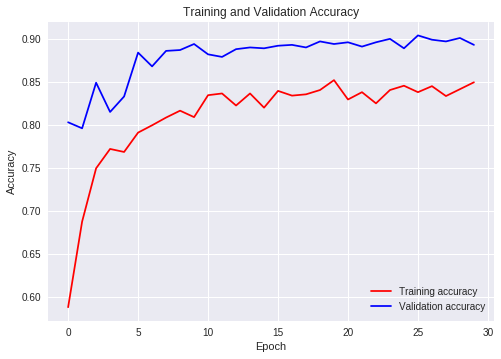

In [33]:
epochs = range(len(train_acc))
plt.plot(epochs, train_acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

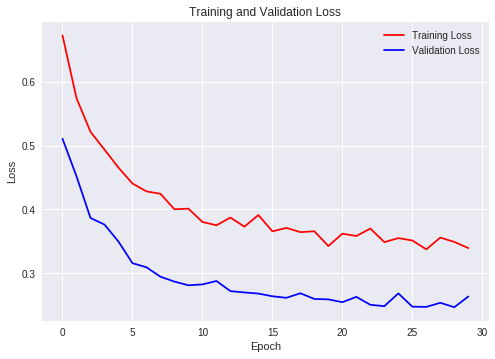

In [34]:
plt.plot(epochs, train_loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()